## Preprocess Input data

In [22]:
import importlib
from src.preprocess import preprocessor  # 모듈을 임포트
importlib.reload(preprocessor)  # 모듈 객체를 reload|

from src.preprocess.preprocessor import Preprocessor  # Preprocessor 클래스를 다시 임포트
prep = Preprocessor()  # Preprocessor 인스턴스 생성

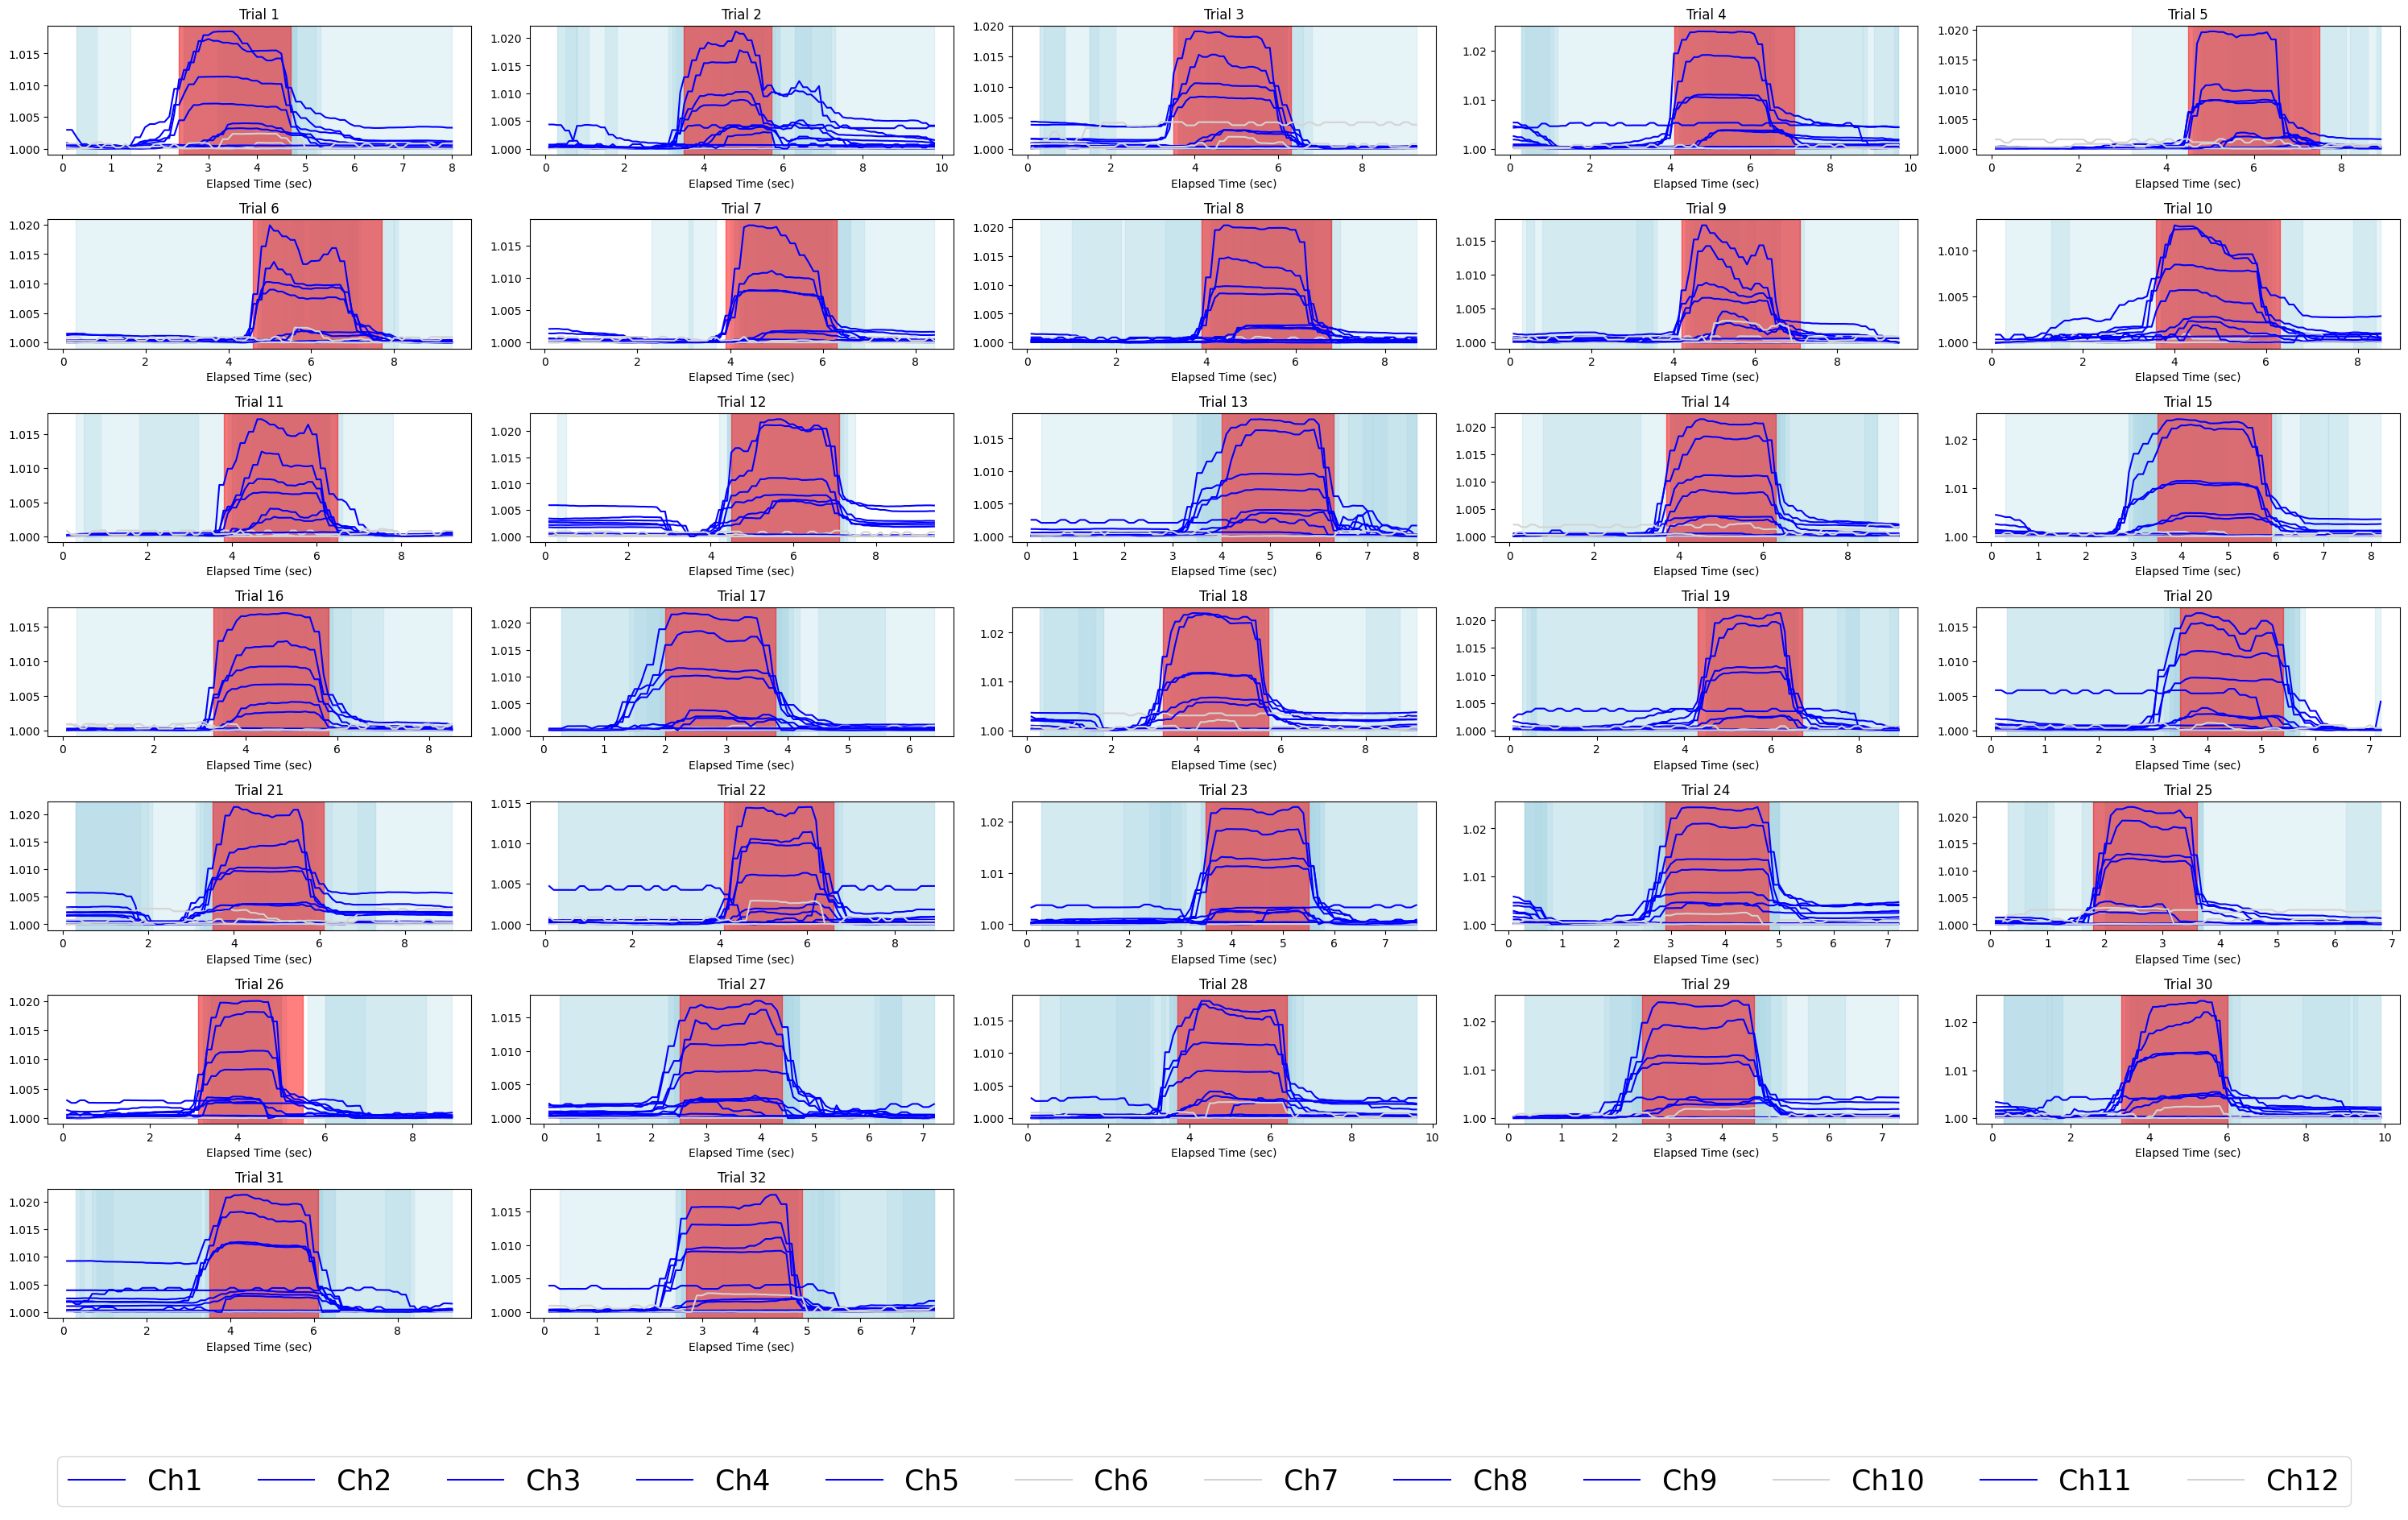

In [23]:
prep = Preprocessor()  # Preprocessor 인스턴스 생성
input_data = prep._load_input_data("coin")
normalized_data = prep._normalize_data(input_data, True, True, True)
rslt = prep._relevant_channels_filtering(normalized_data, trend_threshold=0.004, variance_threshold=0.000008)
rslt = prep._find_sensor_spikes(input_data)
prep._find_overlapping_intervals(min_channels=3, priority_channels=["Ch1", "Ch2", "Ch3", "Ch4"])
# prep._plot_relavant_channel(input_data)
prep._plot_pressed_area(input_data)

In [24]:
prep._save_refined_data(input_data, "coin", "../data/refined")

Preprocessed data saved in ../data/refined/coin_refined.csv


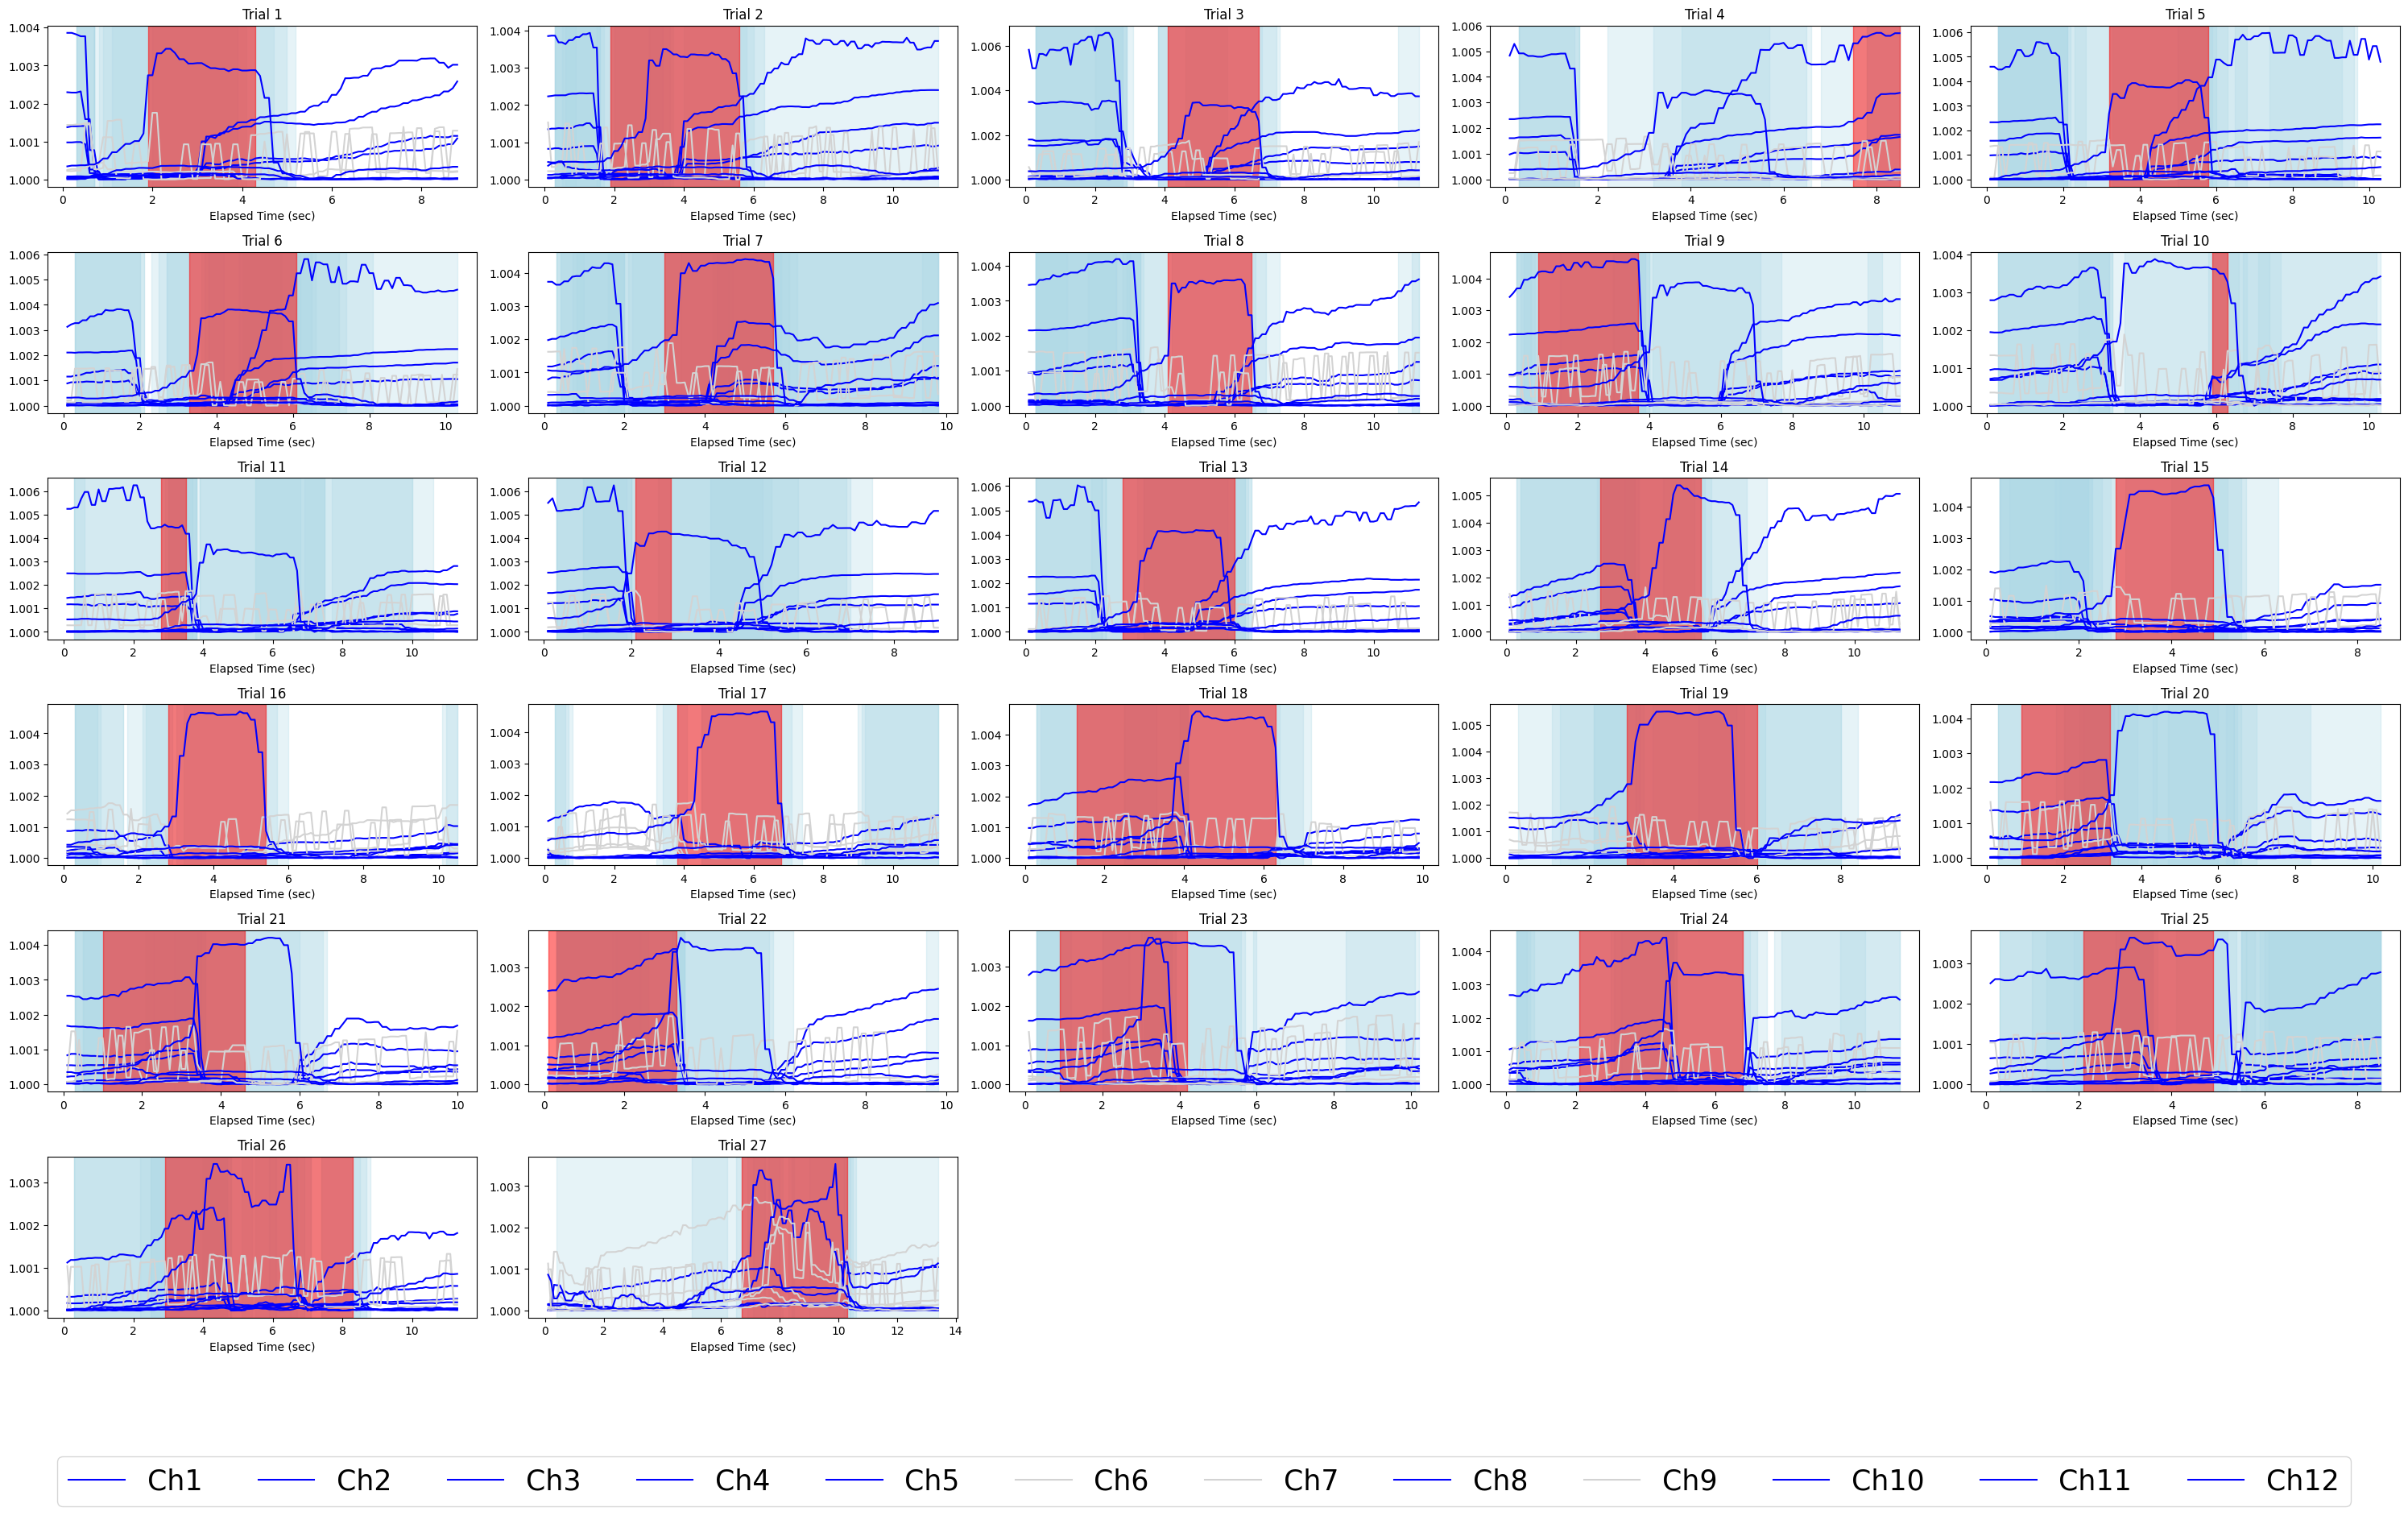

In [25]:
prep = Preprocessor()  # Preprocessor 인스턴스 생성
input_data = prep._load_input_data("weight")
normalized_data = prep._normalize_data(input_data, True, True, True)
rslt = prep._relevant_channels_filtering(normalized_data, trend_threshold=0.004, variance_threshold=0.000008)
rslt = prep._find_sensor_spikes(input_data)
prep._find_overlapping_intervals(min_channels=3, priority_channels=["Ch12", "Ch10"])
# prep._plot_relavant_channel(input_data)
prep._plot_pressed_area(input_data)

In [26]:
prep._save_refined_data(input_data, "weight", "../data/refined")

Preprocessed data saved in ../data/refined/weight_refined.csv


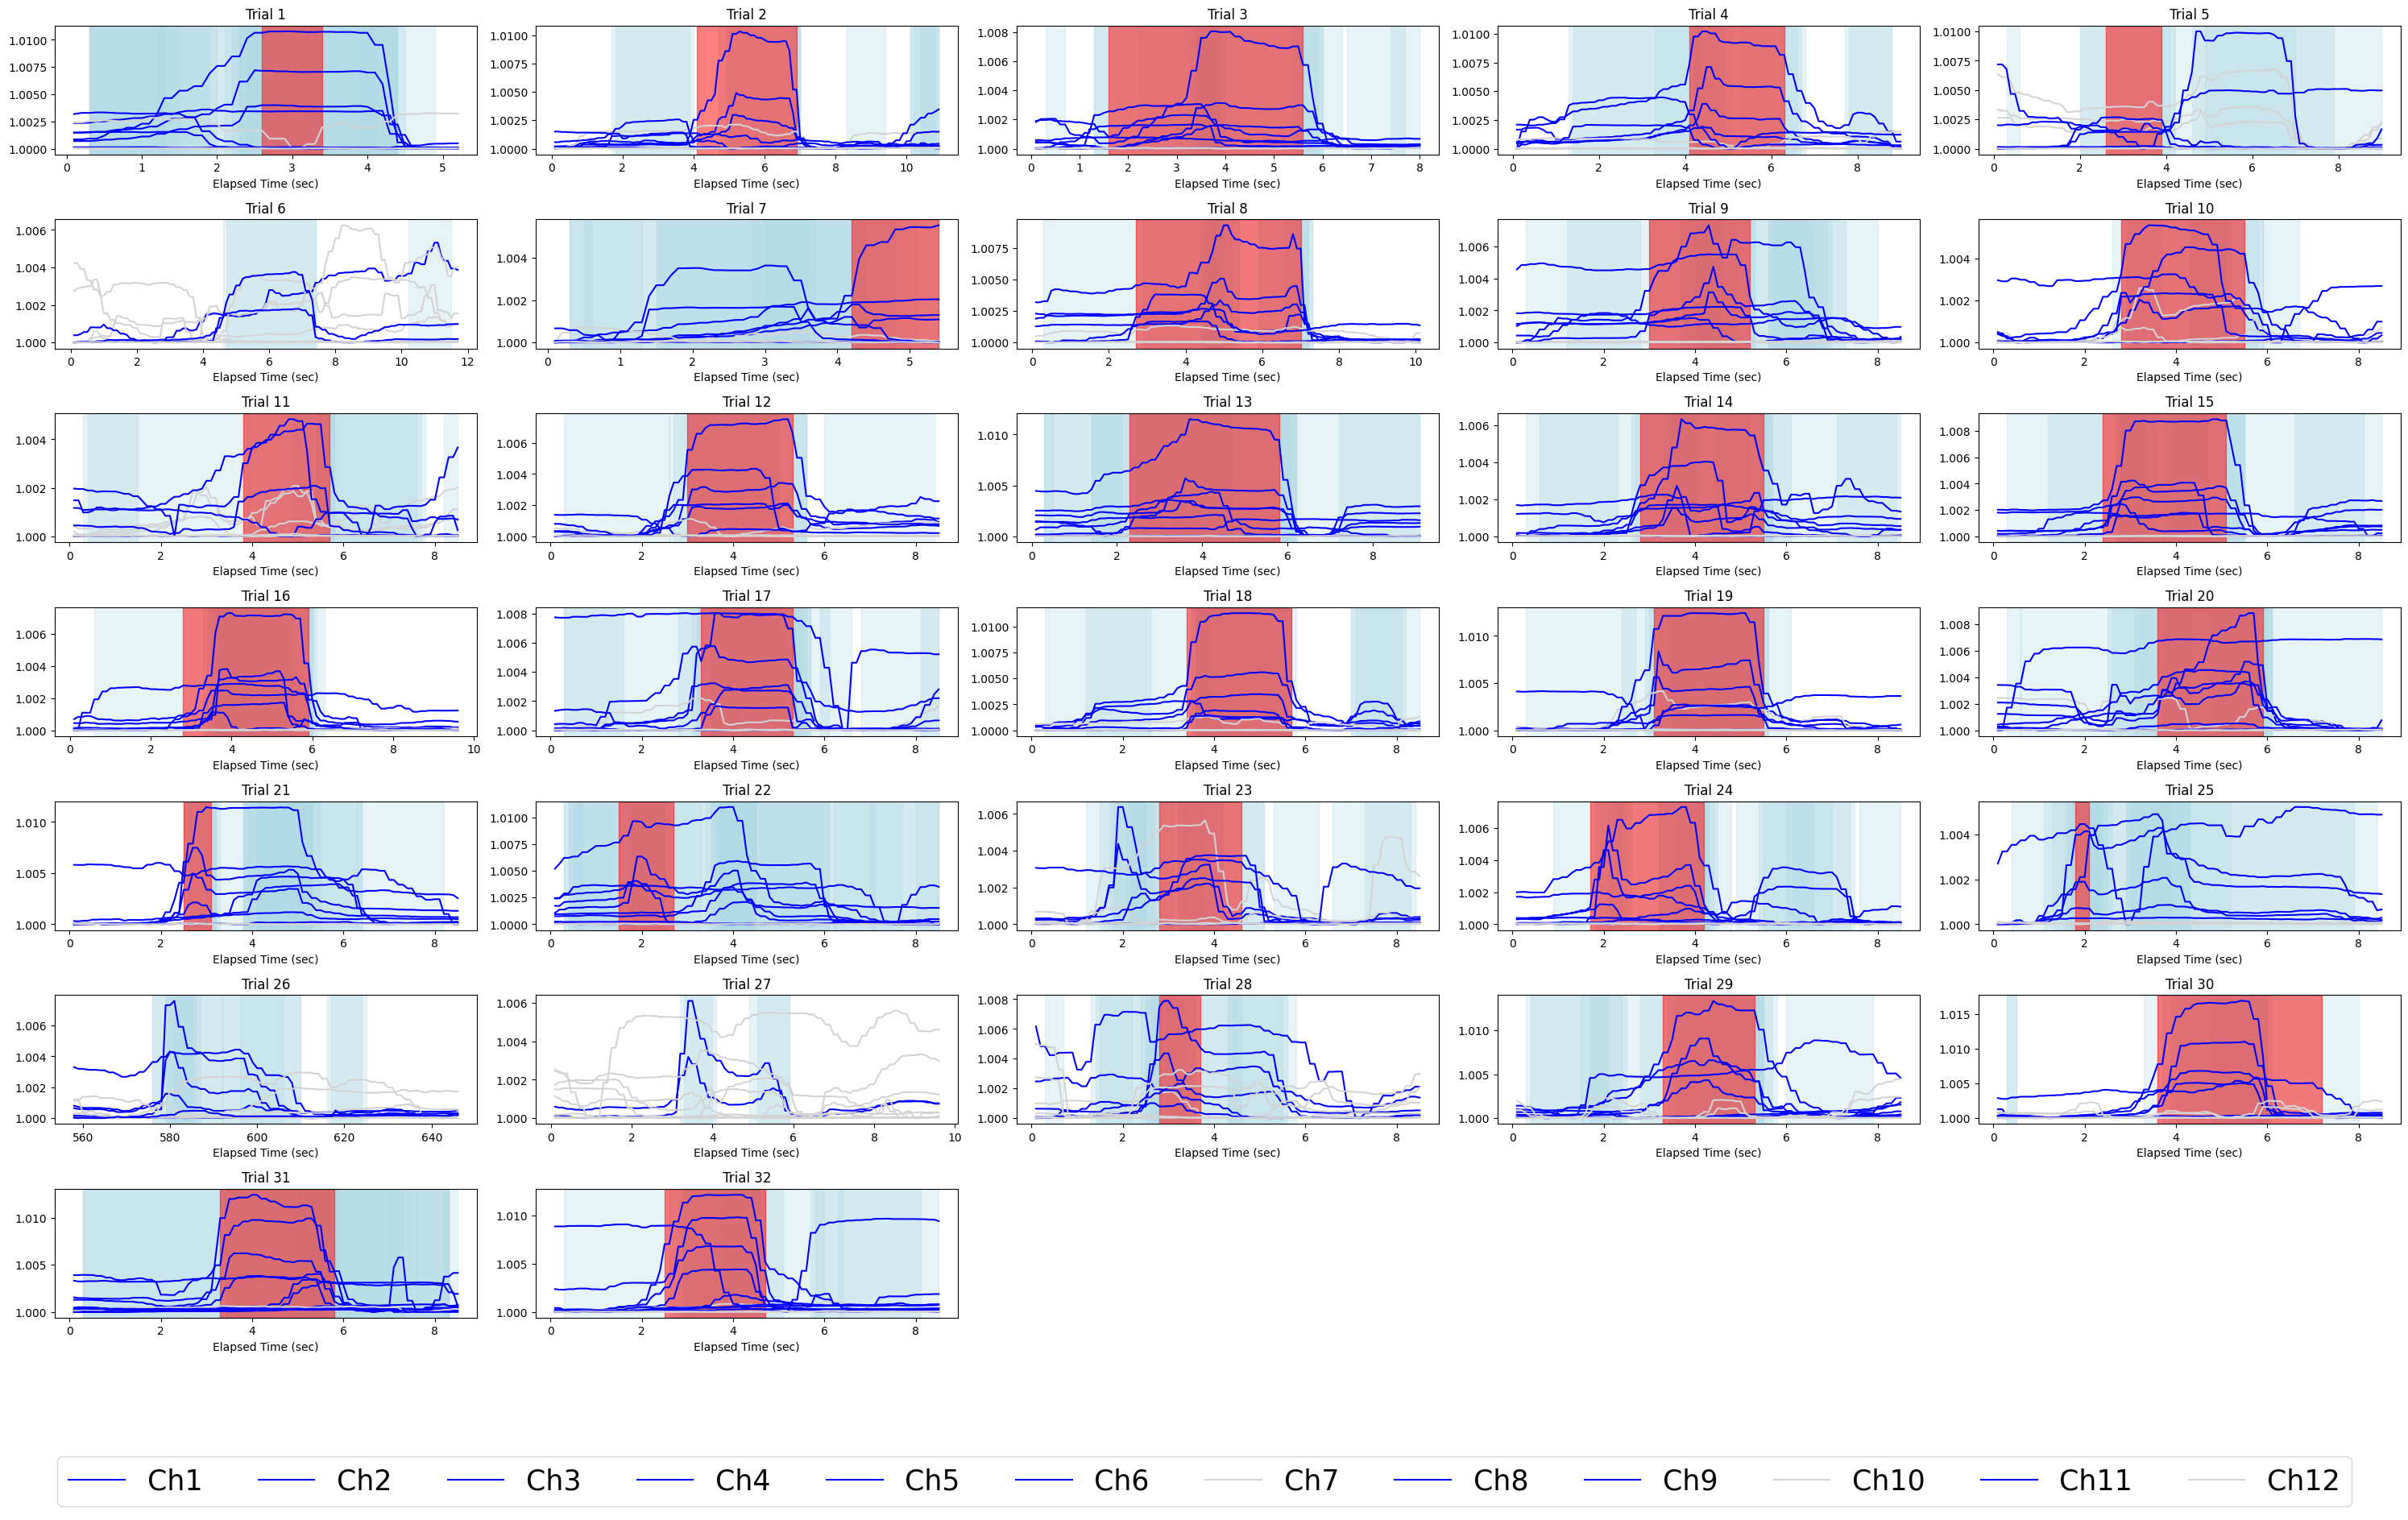

In [27]:
prep = Preprocessor()  # Preprocessor 인스턴스 생성
input_data = prep._load_input_data("card_key")
normalized_data = prep._normalize_data(input_data, True, True, True)
rslt = prep._relevant_channels_filtering(normalized_data, trend_threshold=0.004, variance_threshold=0.000008)
rslt = prep._find_sensor_spikes(input_data)
prep._find_overlapping_intervals(min_channels=3, priority_channels=["Ch4", "Ch9"])
# prep._find_overlapping_intervals(min_channels=3)
# prep._plot_relavant_channel(input_data)
prep._plot_pressed_area(input_data)

In [28]:
prep._save_refined_data(input_data, "card_key", "../data/refined")

Preprocessed data saved in ../data/refined/card_key_refined.csv


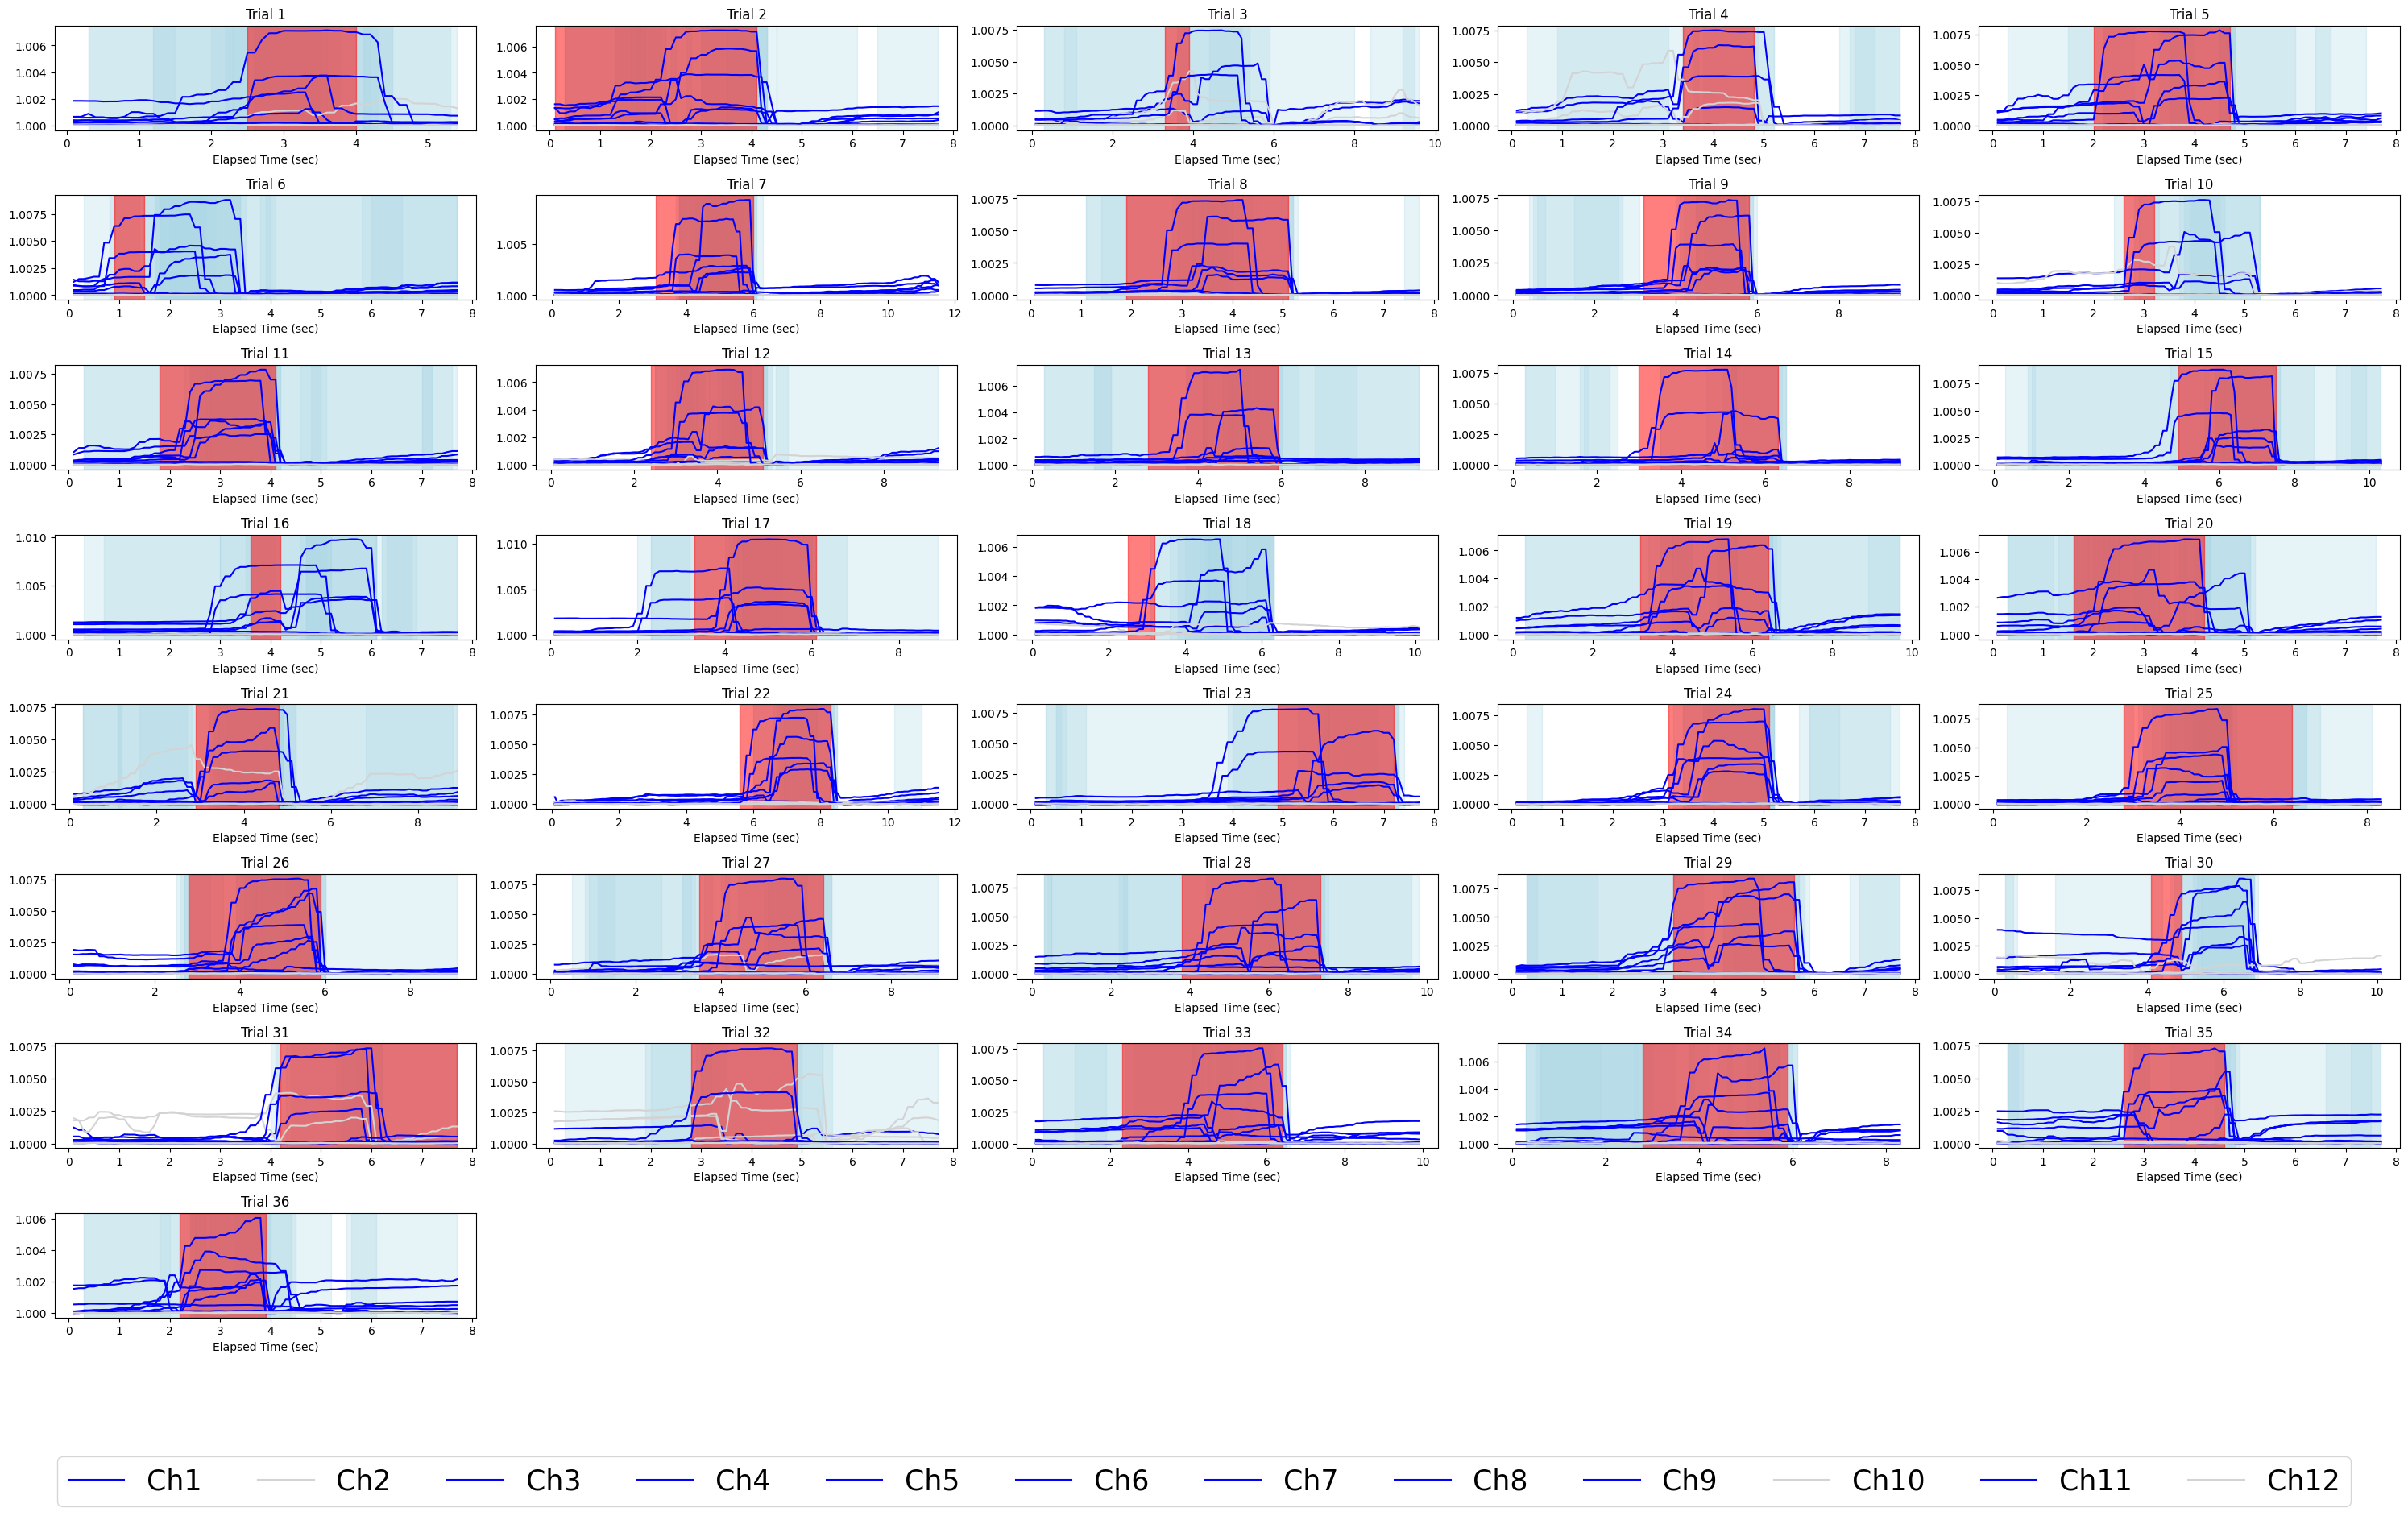

In [29]:
prep = Preprocessor()  # Preprocessor 인스턴스 생성
input_data = prep._load_input_data("touch")
normalized_data = prep._normalize_data(input_data, True, True, True)
rslt = prep._relevant_channels_filtering(normalized_data, trend_threshold=0.004, variance_threshold=0.000008)
rslt = prep._find_sensor_spikes(input_data)
prep._find_overlapping_intervals(min_channels=3, priority_channels=["Ch9", "Ch11"])
# prep._plot_relavant_channel(input_data)
prep._plot_pressed_area(input_data)

In [30]:
prep._save_refined_data(input_data, "touch", "../data/refined")

Preprocessed data saved in ../data/refined/touch_refined.csv


### ETC

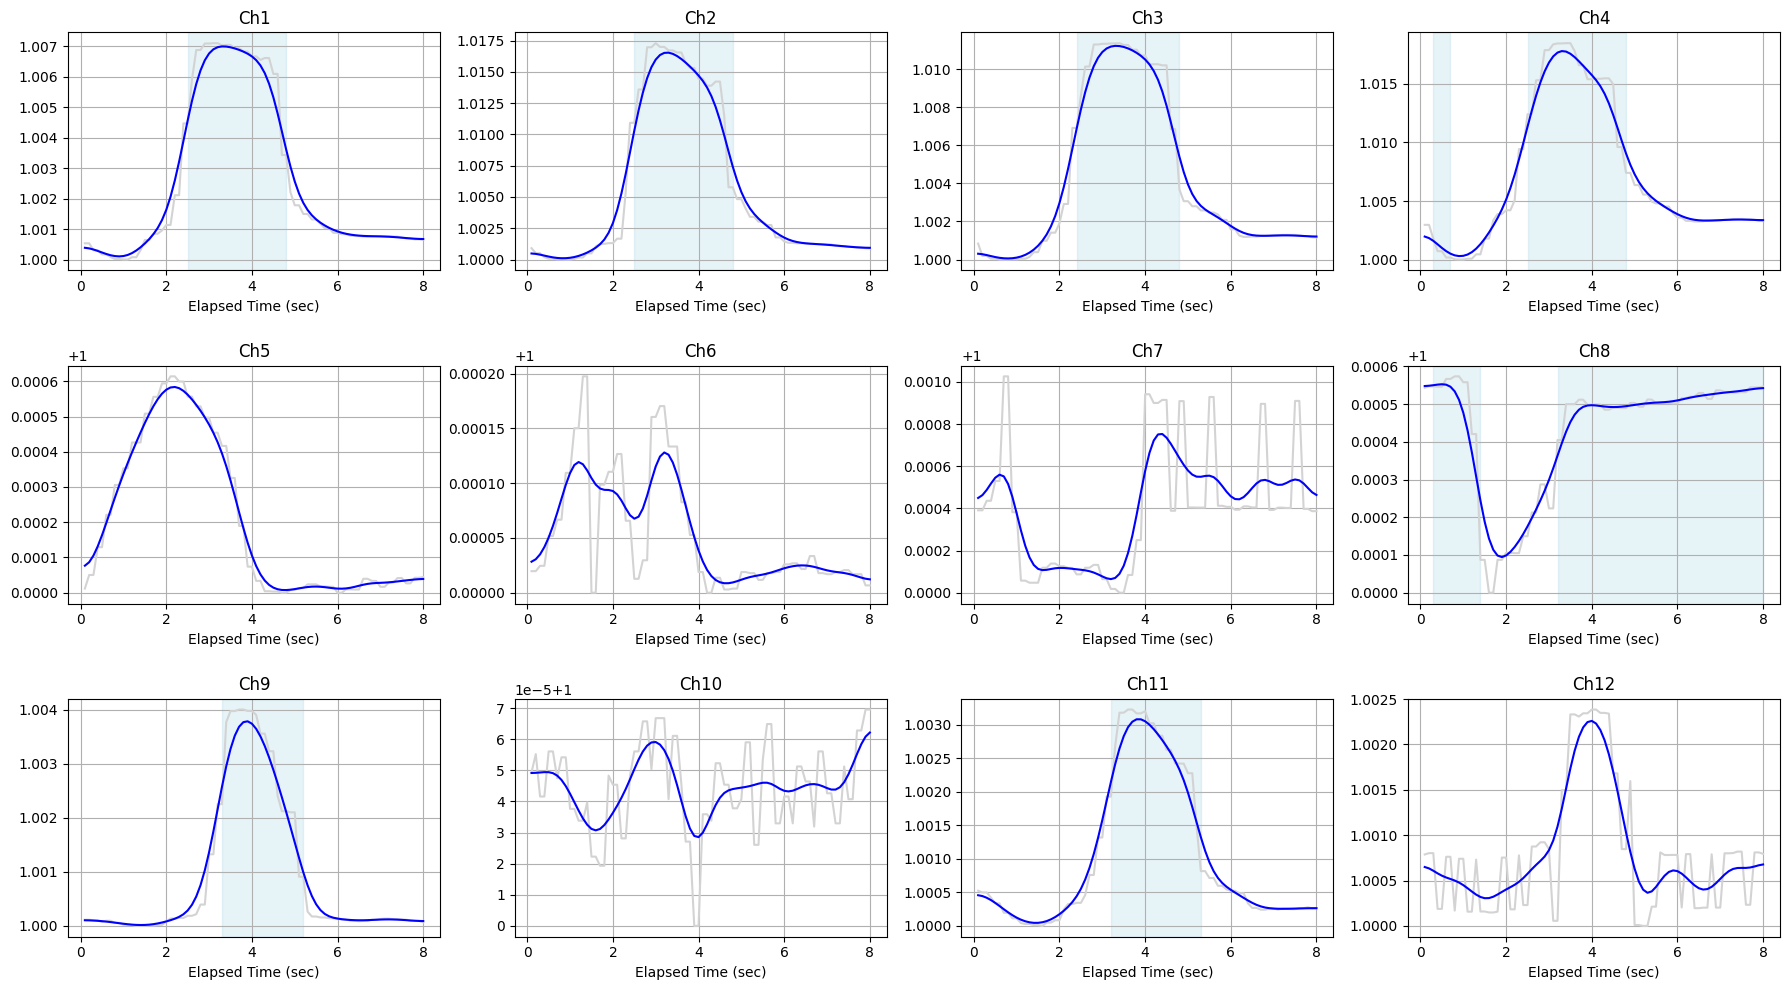

In [1886]:
prep._plot_single_trial(input_data, trial=1)

## Model Train

Epoch 1/200
286/286 [==============================] - 2s 4ms/step - loss: 1.0721 - accuracy: 0.6015 - val_loss: 0.7520 - val_accuracy: 0.7017
Epoch 2/200
286/286 [==============================] - 1s 4ms/step - loss: 0.6022 - accuracy: 0.7793 - val_loss: 0.5274 - val_accuracy: 0.7963
Epoch 3/200
286/286 [==============================] - 1s 4ms/step - loss: 0.4636 - accuracy: 0.8251 - val_loss: 0.4412 - val_accuracy: 0.8318
Epoch 4/200
286/286 [==============================] - 1s 4ms/step - loss: 0.4022 - accuracy: 0.8457 - val_loss: 0.3976 - val_accuracy: 0.8423
Epoch 5/200
286/286 [==============================] - 1s 4ms/step - loss: 0.3661 - accuracy: 0.8583 - val_loss: 0.3688 - val_accuracy: 0.8550
Epoch 6/200
286/286 [==============================] - 1s 4ms/step - loss: 0.3422 - accuracy: 0.8659 - val_loss: 0.3651 - val_accuracy: 0.8541
Epoch 7/200
286/286 [==============================] - 1s 4ms/step - loss: 0.3260 - accuracy: 0.8682 - val_loss: 0.3393 - val_accuracy: 0.8695

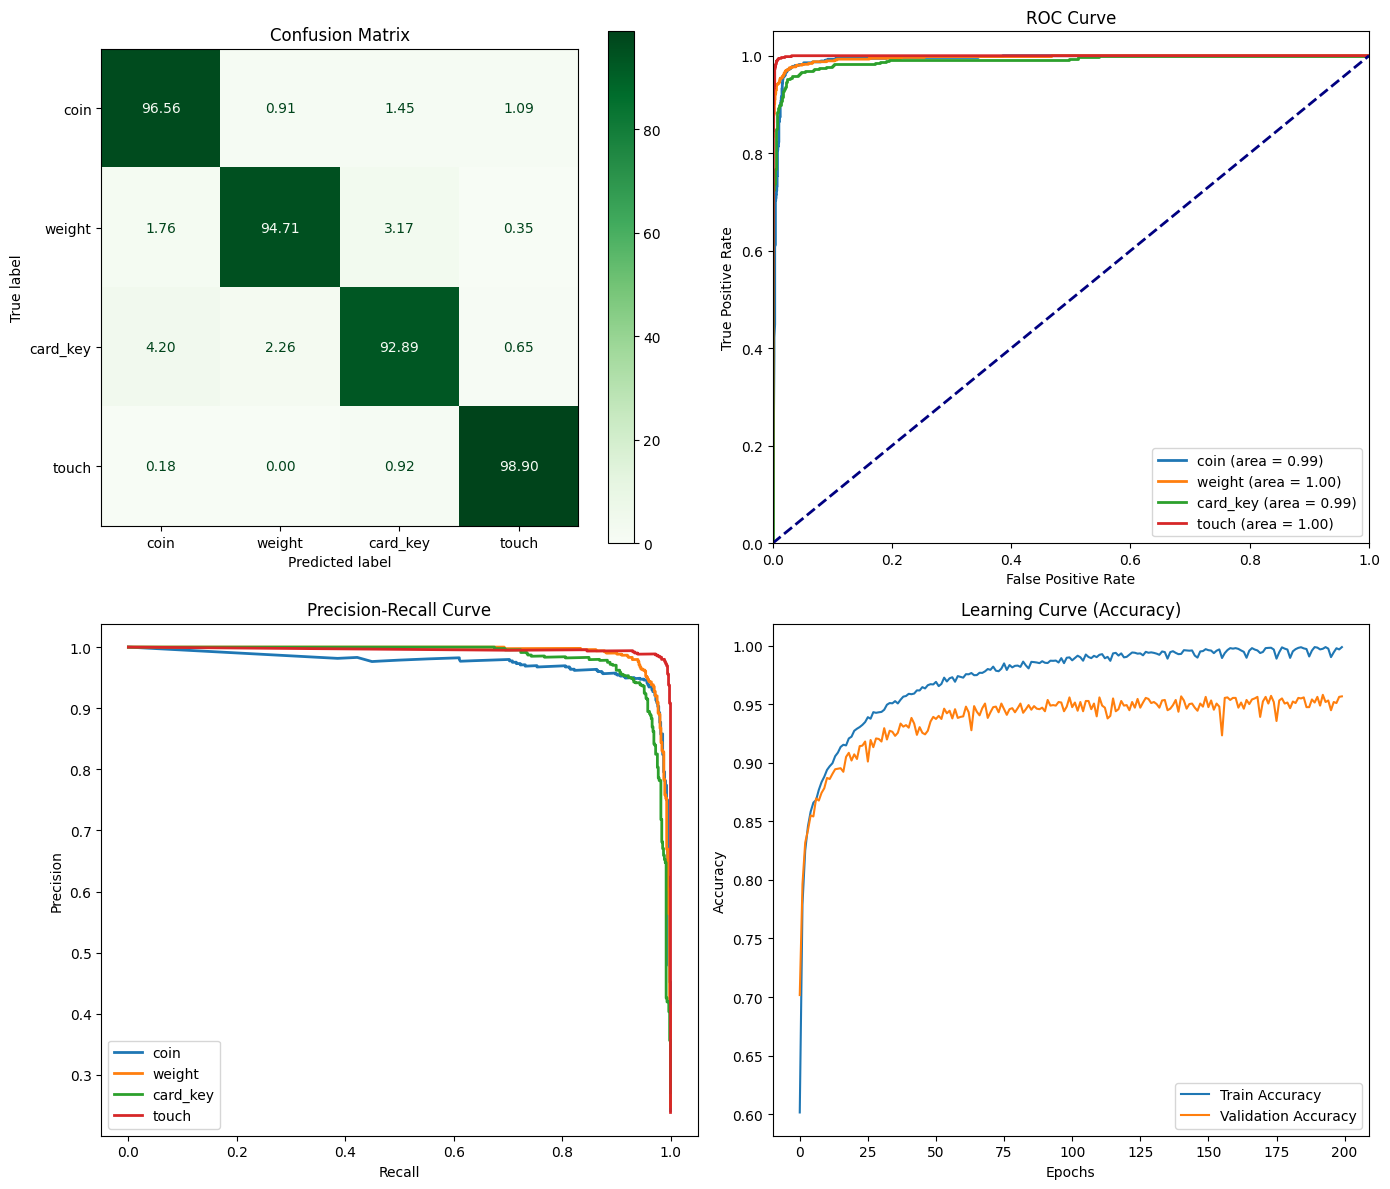

In [53]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# 1. 데이터 로드 및 결합
coin_data = pd.read_csv('../data/refined/coin_refined.csv')
card_key_data = pd.read_csv('../data/refined/card_key_refined.csv')
weight_data = pd.read_csv('../data/refined/weight_refined.csv')
touch_data = pd.read_csv('../data/refined/touch_refined.csv')

# 카테고리 데이터가 이미 포함되어 있으므로 그대로 사용
all_data = pd.concat([coin_data, card_key_data, weight_data, touch_data], ignore_index=True)

# 2. 센서 데이터와 라벨 분리
sensor_data = all_data[['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', 'Ch11', 'Ch12']].values
labels = all_data['category'].values

# 3. 원핫 인코딩
one_hot_labels = pd.get_dummies(labels)

# 4. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(sensor_data, one_hot_labels.values, test_size=0.2, random_state=42)

# 5. 모델 설계 (레이어 수 및 뉴런 수 증가, Dropout과 L2 정규화 제거)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(sensor_data.shape[1],)),  # 레이어 크기 증가
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 6. Adam 옵티마이저의 학습률 조정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 7. 모델 학습 (에포크 수 증가)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

# 8. 모델 평가 및 혼동 행렬 시각화
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
categories = ['coin', 'weight', 'card_key', 'touch']

fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=categories)
disp.plot(cmap=plt.cm.Greens, ax=ax[0, 0], values_format='.2f')
ax[0, 0].set_title('Confusion Matrix')

# 2. ROC 곡선
y_test_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
y_pred_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(one_hot_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 시각화
for i, label in enumerate(categories):
    ax[0, 1].plot(fpr[i], tpr[i], lw=2, label=f'{label} (area = {roc_auc[i]:.2f})')
ax[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0, 1].set_xlim([0.0, 1.0])
ax[0, 1].set_ylim([0.0, 1.05])
ax[0, 1].set_xlabel('False Positive Rate')
ax[0, 1].set_ylabel('True Positive Rate')
ax[0, 1].set_title('ROC Curve')
ax[0, 1].legend(loc='lower right')

# 3. Precision-Recall 곡선
precision = dict()
recall = dict()
for i in range(one_hot_labels.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])

# Precision-Recall 곡선 시각화
for i, label in enumerate(categories):
    ax[1, 0].plot(recall[i], precision[i], lw=2, label=f'{label}')
ax[1, 0].set_xlabel('Recall')
ax[1, 0].set_ylabel('Precision')
ax[1, 0].set_title('Precision-Recall Curve')
ax[1, 0].legend(loc='lower left')

# 4. 학습 곡선 (Learning Curve)
ax[1, 1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_title('Learning Curve (Accuracy)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()